# Tadpole data EDA and modeling
The aim of this notebook is to analyze the numerical data provided in the Tadpole challenge on ADNI using EDA and to use this data for predicting the different Alzheimer's classes. 

In the first part we do the EDA and preprocessing whereas in the second part we focus on using this data for modeling.


In [190]:
# Import all the required packages for data analysis and the EDA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import os
import matplotlib.patches as mpatches
from numpy import isnan

#Import packages for machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer

np.random.seed(42)

# do not show warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [191]:
# Import packages to see models in MLFlow 
import logging
import parsenvy

from logging import getLogger
import mlflow
from config_tp import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='file:///Users/leo92ra/neuefische/ds-capstone-alzheimers-/tadpole_challenge/mlruns/1', experiment_id='1', lifecycle_stage='active', name='alzbusters_numeric_models', tags={}>

In [192]:
# Enable viewing more of the columns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [193]:
#Set a color palette for the notebook 
sns.set_palette(palette='ch:start=.2,rot=-.3')

_______
_______
## EDA and data pre-processing 

In [194]:
# Load processed dataframe
df = pd.read_csv('../tadpole_challenge/df_processed.csv')

In [195]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2155 non-null   int64  
 1   PTID             2155 non-null   object 
 2   AGE              2153 non-null   float64
 3   PTGENDER         2155 non-null   object 
 4   APOE4            2051 non-null   float64
 5   FDG              1355 non-null   float64
 6   AV45             1009 non-null   float64
 7   ABETA            1215 non-null   object 
 8   TAU              1215 non-null   object 
 9   PTAU             1215 non-null   object 
 10  CDRSB            2155 non-null   float64
 11  ADAS11           2138 non-null   float64
 12  ADAS13           2126 non-null   float64
 13  MMSE             2155 non-null   float64
 14  RAVLT_immediate  2138 non-null   float64
 15  Hippocampus      1492 non-null   float64
 16  WholeBrain       1692 non-null   float64
 17  Entorhinal    

We still have some missing values for the brain volume and PET measurements (probably they come from an older dataset). But we do not want to drop them from the dataset now, because they might contain valuable information about the dataset.

### Visualization of distributions and correlations 
So after cleaning the dataframe and removing some missing values, let us visualize some distributions and correlations. 

In [196]:
#Create a pairplot to visualize all the potential correlations in the dataset 
#sns.pairplot(df);

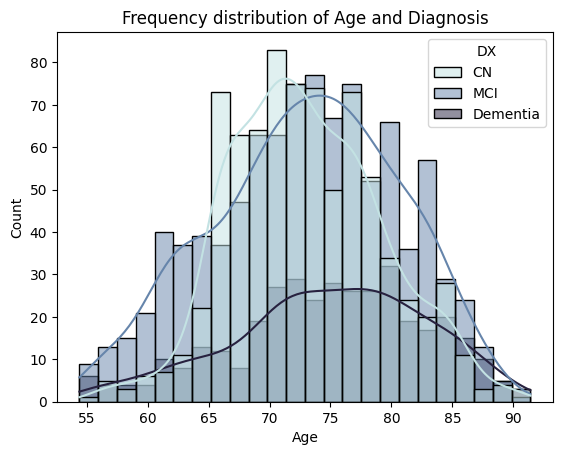

In [197]:
#Create a histogram that shows the distribution of Age and diagnosis in our dataset 
hue_order = ['CN','MCI', 'Dementia']
sns.histplot(data=df, x='AGE', hue='DX',kde=True, palette='ch:start=.2,rot=-.3', hue_order=hue_order).set(xlabel='Age', ylabel='Count')
plt.title('Frequency distribution of Age and Diagnosis');

In [198]:
# Get some statistics about the dataset 
df.describe()

,Unnamed: 0,AGE,APOE4,FDG,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp
count,2155.000000,2153.000000,2051.000000,1355.000000,1009.000000,2155.000000,2138.000000,2126.000000,2155.000000,2138.000000,1492.000000,1.692000e+03,1468.000000,1468.000000
mean,6410.944316,73.298421,0.550463,1.231578,1.204821,1.464269,10.810098,16.708518,27.389791,36.528531,6790.196381,1.021081e+06,3487.057902,19458.201635
std,4701.441565,7.230968,0.660941,0.152706,0.225811,1.761453,6.402462,9.268774,2.641763,12.837831,1185.271732,1.115228e+05,779.966989,3091.601296
min,0.000000,54.400000,0.000000,0.693671,0.805364,0.000000,0.000000,0.000000,17.000000,0.000000,2991.000000,6.693640e+05,1426.000000,9375.000000
25%,2350.500000,68.300000,0.000000,1.141190,1.020030,0.000000,6.000000,10.000000,26.000000,27.000000,5948.000000,9.405800e+05,2951.000000,17485.000000
50%,4861.000000,73.300000,0.000000,1.242680,1.126540,1.000000,9.330000,15.000000,28.000000,36.000000,6864.000000,1.015730e+06,3508.500000,19418.500000
75%,11618.500000,78.400000,1.000000,1.332395,1.377340,2.000000,14.000000,22.000000,29.000000,46.000000,7651.250000,1.095870e+06,4040.500000,21525.250000
max,13911.000000,91.400000,2.000000,1.701130,2.025560,10.000000,42.670000,54.670000,30.000000,71.000000,10769.000000,1.486040e+06,5896.000000,32189.000000


So the mean age in our dataset is 73 years and the mean MMSE is 27.

In [199]:
# Let us find out how many unique values we have in each column 
df.nunique()

Unnamed: 0         2155
PTID               2155
AGE                 335
PTGENDER              2
APOE4                 3
FDG                1330
AV45               1004
ABETA               960
TAU                1044
PTAU               1047
CDRSB                18
ADAS11              103
ADAS13              140
MMSE                 14
RAVLT_immediate      69
Hippocampus        1265
WholeBrain         1669
Entorhinal         1159
MidTemp            1379
DX                    3
dtype: int64

In [200]:
#Count the total number of entries for the three different APOE4 expression levels 

df.groupby(['APOE4']).DX.count()

APOE4
0.0    1114
1.0     739
2.0     194
Name: DX, dtype: int64

In [201]:
#We create a new dataframe with the entries grouped by the Alzheimer stage 
df_apo=pd.pivot_table(df, index=['APOE4', 'DX'], values='PTID',aggfunc='count').reset_index()
df_apo

,APOE4,DX,PTID
0,0.0,CN,529
1,0.0,Dementia,119
2,0.0,MCI,466
3,1.0,CN,209
4,1.0,Dementia,167
5,1.0,MCI,363
6,2.0,CN,21
7,2.0,Dementia,71
8,2.0,MCI,102


In [202]:
#Create a list with the totals that we want to normalize the entries in the pivot to 
totals=[1114,1114,1114,739,739,739,194,194,194]

In [203]:
# Normalize entries in the list to the total number per APOE4 class 
df_apo['ratio']=(df_apo['PTID']/totals)*100
df_apo

,APOE4,DX,PTID,ratio
0,0.0,CN,529,47.486535
1,0.0,Dementia,119,10.682226
2,0.0,MCI,466,41.831239
3,1.0,CN,209,28.281461
4,1.0,Dementia,167,22.598106
5,1.0,MCI,363,49.120433
6,2.0,CN,21,10.824742
7,2.0,Dementia,71,36.597938
8,2.0,MCI,102,52.577320


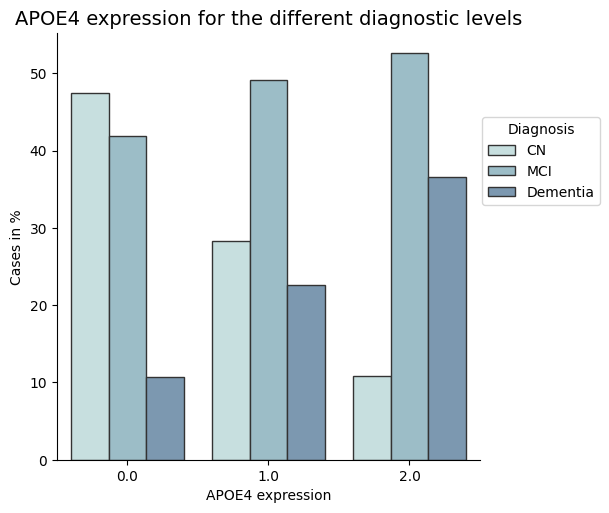

In [204]:
# So let us find out how diagnosis is correlated with the APOE4 gene expression. 
hue_order=['CN', 'MCI', 'Dementia'] 
sns.catplot(data=df_apo, kind='bar', x='APOE4', y='ratio', hue='DX', hue_order=hue_order, edgecolor=".2", legend=None).set(xlabel='APOE4 expression', ylabel='Cases in %')
plt.legend(title='Diagnosis', bbox_to_anchor=(1.3,0.7), loc='right')
plt.title('APOE4 expression for the different diagnostic levels', fontsize=14);

We see in this plot, that indeed the higher expression of APOE4 is associated with a higher number of patients diagnosed with mild cognitive impairment or dementia. In the next section, let us find out how the different brain parameters correlate with the diagnosis. 

In [205]:
df_brain=pd.pivot_table(df, index='DX', values=['Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp'],aggfunc='mean').reset_index()


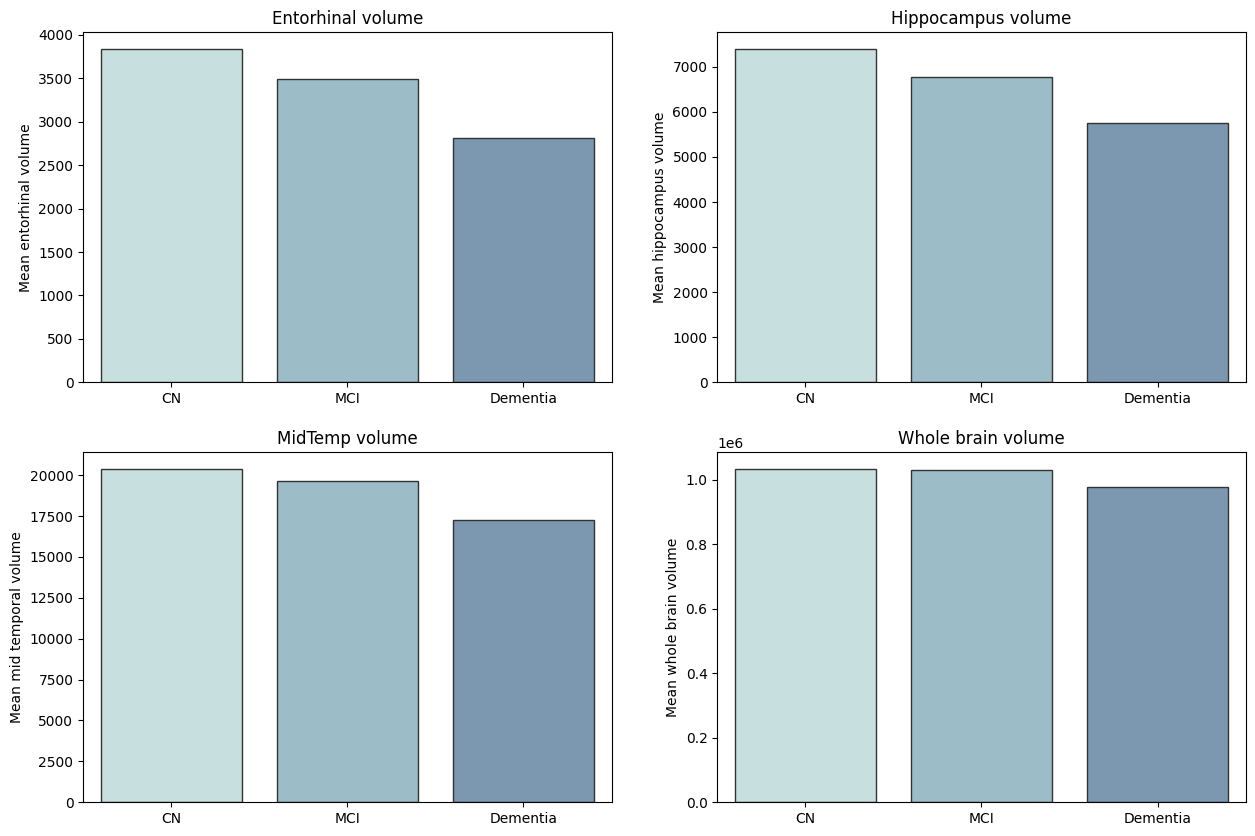

In [206]:
#Create plots with all four different categories 
fig, axes = plt.subplots(2,2, figsize=(15,10))

#Entorhinal
sns.barplot(ax=axes[0,0],data=df_brain, x='DX', y='Entorhinal', order=['CN', 'MCI', 'Dementia'], edgecolor=".2").set(xlabel=None, ylabel='Mean entorhinal volume')
axes[0,0].set_title('Entorhinal volume');

#Hippocampus 
sns.barplot(ax=axes[0,1],data=df_brain, x='DX', y='Hippocampus', order=['CN', 'MCI', 'Dementia'], edgecolor=".2").set(xlabel=None, ylabel='Mean hippocampus volume')
axes[0,1].set_title('Hippocampus volume');

#MidTemp 
sns.barplot(ax=axes[1,0],data=df_brain, x='DX', y='MidTemp', order=['CN', 'MCI', 'Dementia'], edgecolor=".2").set(xlabel=None, ylabel='Mean mid temporal volume')
axes[1,0].set_title('MidTemp volume');

#WholeBrain
sns.barplot(ax=axes[1,1],data=df_brain, x='DX', y='WholeBrain', order=['CN', 'MCI', 'Dementia'], edgecolor=".2").set(xlabel=None, ylabel='Mean whole brain volume')
axes[1,1].set_title('Whole brain volume');

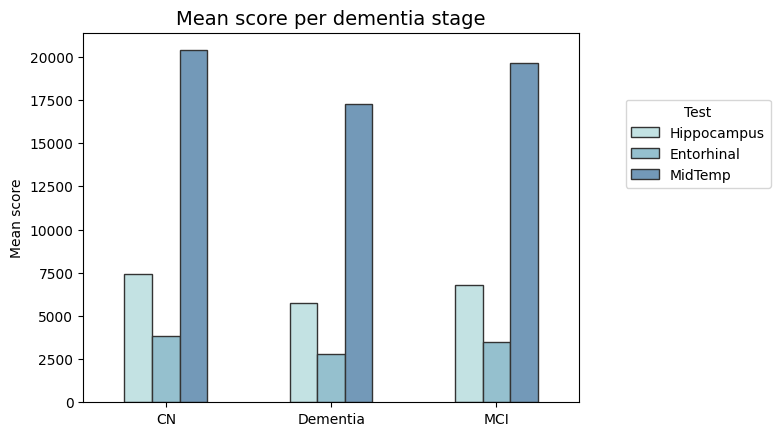

In [207]:
df_brain.plot(x='DX', y=['Hippocampus', 'Entorhinal', 'MidTemp'], kind='bar', edgecolor=".2").set(xlabel=None, ylabel='Mean score')
plt.legend(title='Test', bbox_to_anchor=(1.4,0.7), loc='right')
plt.title('Mean score per dementia stage', fontsize=14)
plt.xticks(rotation=0)
plt.show();

In [208]:
df_test=pd.pivot_table(df, index='DX', values=['MMSE', 'ADAS11', 'ADAS13', 'RAVLT_immediate'],aggfunc='mean').reset_index()
df_test
df_test=df_test.reindex([0,2,1])

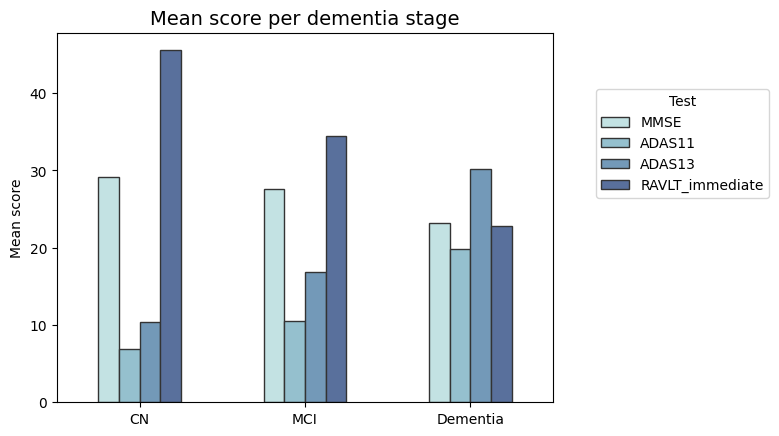

In [209]:
df_test.plot(x='DX', y=['MMSE', 'ADAS11', 'ADAS13', 'RAVLT_immediate'], kind='bar', edgecolor=".2").set(xlabel=None, ylabel='Mean score')
plt.legend(title='Test', bbox_to_anchor=(1.45,0.7), loc='right')
plt.title('Mean score per dementia stage', fontsize=14)
plt.xticks(rotation=0)
plt.show();


In [210]:
df.columns

Index(['Unnamed: 0', 'PTID', 'AGE', 'PTGENDER', 'APOE4', 'FDG', 'AV45',
       'ABETA', 'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
       'RAVLT_immediate', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp',
       'DX'],
      dtype='object')

In [211]:
#Check if we only have every subject ones 
df.PTID.nunique()

2155

_____
______
## Modeling 

For the numeric data we start with some very simple basic machine learning models and see how they perform. We need to also scale the numeric values to have them in a similar range. 

In [212]:
#Since we will get problems with the NaN values, we just start with dropping all NaN values. If this leads to bad modelling we can change this later. 
df.dropna(axis=0, inplace=True)

#drop the column with the IDs and strange symbols
df.drop(columns=df[['PTID','ABETA','PTAU']], inplace=True)

In [213]:
#Convert everything to numerical values 
df[['TAU']].astype(float)

,TAU
18,101.20
19,170.40
30,347.80
36,324.80
90,108.20
...,...
1792,279.90
1793,314.60
1794,305.00
1796,300.10


In [214]:
df.head(2)

,Unnamed: 0,AGE,PTGENDER,APOE4,FDG,AV45,TAU,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp,DX
18,76,67.5,Male,0.0,1.25096,0.983143,101.2,0.0,3.0,5.0,30.0,42.0,8297.0,1165500.0,4946.0,21194.0,CN
19,77,68.5,Male,0.0,1.49677,0.985156,170.4,0.0,4.0,7.0,30.0,61.0,7654.0,1081140.0,4065.0,18611.0,CN


In [215]:
# Use get_dummies for the PTGENDER and APOE4 column 
df=pd.get_dummies(df, columns=['PTGENDER', 'APOE4'], drop_first=False)


In [216]:
#Train-test-split 
X=df.drop('DX', axis=1)
y=df['DX']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, random_state=42)

In [217]:
print(X_test.shape)
print(X_train.shape)

(161, 19)
(480, 19)


In [218]:
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [219]:
# setting the MLFlow connection and experiment
#mlflow.start_run(run_name='1_log_reg_scaled')
#run = mlflow.active_run()

_______
### 1. Logistic regression
### 1.1 Logistic regression - entire numeric df


In [220]:
#Run a simple logistic regression model 

log_reg=LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_train=log_reg.predict(X_train)
y_pred=log_reg.predict(X_test_scaled)

In [221]:
y_train

1418         MCI
1449          CN
1450    Dementia
752          MCI
736          MCI
          ...   
1244         MCI
841          MCI
941          MCI
1143         MCI
1141         MCI
Name: DX, Length: 480, dtype: object

In [222]:
# Check out the metrics
acc_test = accuracy_score(y_test, y_pred)
print(acc_test)
acc_train=accuracy_score(y_train, log_reg.predict(X_train_scaled))

0.8881987577639752


accuracy:  0.89


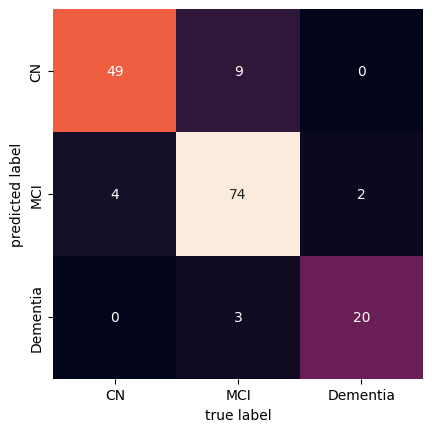

In [223]:
# Plotting the confusing matrix
labels=['CN', 'MCI', 'Dementia']
mat = confusion_matrix(y_test, y_pred, labels=labels)
cm=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
cm.set_xticklabels(labels)
cm.set_yticklabels(labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred).round(2))
#print('recall: ' , recall_score(y_test, y_pred).round(2))
#print('precision: ' , precision_score(y_test, y_pred).round(2))

In [224]:
"""
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)
"""

'\n#logging metrics\nmlflow.log_metric("train-" + "accuracy", acc_train)\nmlflow.log_metric("test-" + "accuracy", acc_test)\n\n# mlflow.sklearn.log_model(reg, "model")\nmlflow.end_run()\n\nmlflow.get_run(run_id=run.info.run_id)\n'

### 1.2 Logistic regression - df_other 

In the second approach the dataframe was processed in a slightly different way to see if this changes the outcome in the model. For the we divided the dataframe into two, one representing all the brain correlated data and the other one containing the other information.

In [225]:
#We load the csv file again and apply the modification done by Leonardo 
df = pd.read_csv("../tadpole_challenge/df_processed.csv")
df.head(2)

,Unnamed: 0,PTID,AGE,PTGENDER,APOE4,FDG,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp,DX
0,0,011_S_0002,74.3,Male,0.0,1.36665,NaN,NaN,NaN,NaN,0.0,10.67,18.67,28.0,44.0,8336.0,1229740.0,4177.0,27936.0,CN
1,1,011_S_0003,81.3,Male,1.0,1.08355,NaN,741.5,239.7,22.83,4.5,22.00,31.00,20.0,22.0,5319.0,1129830.0,1791.0,18422.0,Dementia


In [226]:
# drop Unnamed column and PTID (no information)
df.drop(["Unnamed: 0","PTID"],axis=1,inplace=True)

Since there are so many empty entries in the brain MRI and PET measurements which will also lead to dropping of the other information if we delete the NaN we decided separate the df into df_other and df_brain. 

In [227]:
df.columns

Index(['AGE', 'PTGENDER', 'APOE4', 'FDG', 'AV45', 'ABETA', 'TAU', 'PTAU',
       'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'Hippocampus',
       'WholeBrain', 'Entorhinal', 'MidTemp', 'DX'],
      dtype='object')

In [228]:
# Use get_dummies for the PTGENDER and APOE4 column 
df=pd.get_dummies(df, columns=['PTGENDER'], drop_first=False)

In [229]:
df.columns

Index(['AGE', 'APOE4', 'FDG', 'AV45', 'ABETA', 'TAU', 'PTAU', 'CDRSB',
       'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate', 'Hippocampus',
       'WholeBrain', 'Entorhinal', 'MidTemp', 'DX', 'PTGENDER_Female',
       'PTGENDER_Male'],
      dtype='object')

In [230]:
#Create the df_other dataframe by dropping the brain related columns 
col_other = ['FDG', 'AV45', 'ABETA', 'TAU', 'PTAU','Hippocampus','WholeBrain', 'Entorhinal', 'MidTemp']
df_other=df.drop(col_other, inplace=False, axis=1)


In [231]:
df_other.head(2)

,AGE,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,DX,PTGENDER_Female,PTGENDER_Male
0,74.3,0.0,0.0,10.67,18.67,28.0,44.0,CN,0,1
1,81.3,1.0,4.5,22.00,31.00,20.0,22.0,Dementia,0,1


In [232]:
df_other.isnull().sum()

AGE                  2
APOE4              104
CDRSB                0
ADAS11              17
ADAS13              29
MMSE                 0
RAVLT_immediate     17
DX                  33
PTGENDER_Female      0
PTGENDER_Male        0
dtype: int64

In [233]:
#Drop the rows in DX that are empty 
df_other.dropna(subset=["DX"], inplace=True)

In [234]:
df_other.isnull().sum()

AGE                 2
APOE4              75
CDRSB               0
ADAS11              5
ADAS13             16
MMSE                0
RAVLT_immediate     5
DX                  0
PTGENDER_Female     0
PTGENDER_Male       0
dtype: int64

In [235]:
#Train test split for the df_other dataframe to avoid data leakage into our test set 
X_other= df_other.drop('DX', axis=1)
y_other=df_other['DX']
X_train_other, X_test_other, y_train_other, y_test_other=train_test_split(X_other, y_other, random_state=42, stratify=y_other)

In [236]:
df_other.groupby('DX').mean()

,AGE,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,PTGENDER_Female,PTGENDER_Male
DX,,,,,,,,,
CN,72.982911,0.330698,0.036662,6.904068,10.321017,29.094817,45.537389,0.552465,0.447535
Dementia,74.878320,0.865546,4.403794,19.835613,30.159751,23.151762,22.751366,0.441734,0.558266
MCI,72.990843,0.609023,1.507277,10.494651,16.803079,27.613306,34.412682,0.408524,0.591476


In [237]:
X_train_other['AGE'].fillna(X_train_other['AGE'].mean(), inplace=True);
X_test_other['AGE'].fillna(X_train_other['AGE'].mean(), inplace=True);

In [238]:
#Use the KNN imputer to fill the other missing values in the X_train and apply this to X_test 
#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train_other)

# transform X_train und X_test
X_train_other = imputer.transform(X_train_other)
X_test_other = imputer.transform(X_test_other)

In [239]:
# make arrays X_train_other and X_test_other into dataframes for plotting
columns=['AGE', 'APOE4', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate','PTGENDER_Female', 'PTGENDER_Male']
data_train = np.array(X_train_other)
X_train_other = pd.DataFrame(data=data_train, columns=columns)
data_test = np.array(X_test_other)
X_test_other = pd.DataFrame(data=data_test, columns=columns)

In [240]:
print("Missing in train:")
print(X_train_other.isnull().sum())
print("====================")
print("Missing in test:")
print(X_test_other.isnull().sum())

Missing in train:
AGE                0
APOE4              0
CDRSB              0
ADAS11             0
ADAS13             0
MMSE               0
RAVLT_immediate    0
PTGENDER_Female    0
PTGENDER_Male      0
dtype: int64
Missing in test:
AGE                0
APOE4              0
CDRSB              0
ADAS11             0
ADAS13             0
MMSE               0
RAVLT_immediate    0
PTGENDER_Female    0
PTGENDER_Male      0
dtype: int64


In [241]:
X_train_other.head(3)

,AGE,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,PTGENDER_Female,PTGENDER_Male
0,70.3,0.0,0.0,4.00,9.00,28.0,46.0,1.0,0.0
1,70.6,0.0,0.0,7.67,12.67,29.0,39.0,1.0,0.0
2,78.4,0.0,0.0,9.00,14.00,30.0,34.0,0.0,1.0


In [242]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_other=scaler.fit_transform(X_train_other)
X_test_other=scaler.transform(X_test_other)

# transform back array into dataframe (just for easier manipulation, this step does not change the results)
data_train = np.array(X_train_other)
X_train_other = pd.DataFrame(data=data_train, columns=columns)
data_test = np.array(X_test_other)
X_test_other = pd.DataFrame(data=data_test, columns=columns)

In [243]:
X_train_other.head(3)

,AGE,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,PTGENDER_Female,PTGENDER_Male
0,-0.436481,-0.842152,-0.832689,-1.056747,-0.829123,0.235634,0.727368,1.044352,-1.044352
1,-0.394529,-0.842152,-0.832689,-0.484639,-0.433659,0.616236,0.184455,1.044352,-1.044352
2,0.696206,-0.842152,-0.832689,-0.277309,-0.290344,0.996838,-0.203340,-0.957532,0.957532


We continue with trying again the logistic regression and compare it to the first one. 

In [244]:
# setting the MLFlow connection and experiment
#mlflow.start_run(run_name='2_log_reg_other_scaled_trans')
#run = mlflow.active_run()

In [245]:
#Run a simple logistic regression model 

log_reg=LogisticRegression(max_iter=1000)
log_reg.fit(X_train_other, y_train_other)

y_pred_train_other=log_reg.predict(X_train_other)
y_pred_other=log_reg.predict(X_test_other)

In [246]:
# Check out the metrics
acc_test = accuracy_score(y_test_other, y_pred_other)
print(acc_test)
acc_train=accuracy_score(y_train_other, log_reg.predict(X_train_other))
print(acc_train)

0.9322033898305084
0.9352608422375864


accuracy:  0.93


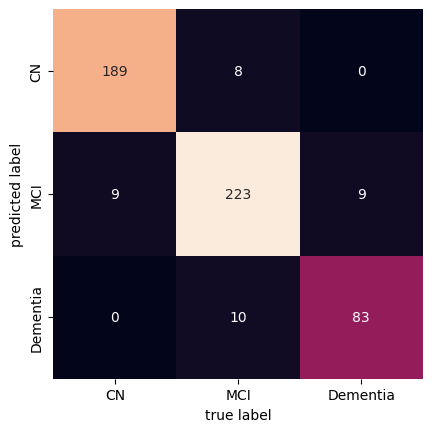

In [247]:
# Plotting the confusing matrix
labels=['CN', 'MCI', 'Dementia']
mat = confusion_matrix(y_test_other, y_pred_other, labels=labels)
cm=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
cm.set_xticklabels(labels)
cm.set_yticklabels(labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test_other, y_pred_other).round(2))
#print('recall: ' , recall_score(y_test, y_pred).round(2))
#print('precision: ' , precision_score(y_test, y_pred).round(2))

In [248]:
'''
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)
'''

'\n#logging metrics\nmlflow.log_metric("train-" + "accuracy", acc_train)\nmlflow.log_metric("test-" + "accuracy", acc_test)\n\n# mlflow.sklearn.log_model(reg, "model")\nmlflow.end_run()\n\nmlflow.get_run(run_id=run.info.run_id)\n'

In [249]:
"""
mlflow.get_run(run_id=run.info.run_id)
"""


'\nmlflow.get_run(run_id=run.info.run_id)\n'

### 1.3 Logistic regression - df_brain

For the next part, we created a dataframe only containing the information with the brain related structures. 

In [250]:
#Create the df_brain dataframe by dropping the other related columns 
col_brain = ['AGE', 'APOE4', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate','PTGENDER_Female', 'PTGENDER_Male']
df_brain=df.drop(col_brain, inplace=False, axis=1)

In [251]:
df_brain.isnull().sum()

FDG             800
AV45           1146
ABETA           940
TAU             940
PTAU            940
Hippocampus     663
WholeBrain      463
Entorhinal      687
MidTemp         687
DX               33
dtype: int64

In [252]:
#Replace all the weird values (< or >) with the NaN to have them predicted with the imputer 
df_brain["PTAU"].replace("<8",np.nan, inplace=True)
df_brain["PTAU"].replace(">120",np.nan, inplace=True)
df_brain["ABETA"].replace("<200",np.nan, inplace=True)
df_brain["ABETA"].replace(">1700",np.nan, inplace=True)
df_brain["TAU"].replace("<80",np.nan, inplace=True)
df_brain["TAU"].replace(">1300",np.nan, inplace=True)

In [253]:
#Drop the rows in DX that are empty 
df_brain.dropna(subset=["DX"], inplace=True)

#### 1.3.1 Logistic regression of df_brain - trial with NaN filled with KNN

In [254]:
#Train test split for the df_brain dataframe to avoid data leakage into our test set 
X_brain= df_brain.drop('DX', axis=1)
y_brain=df_brain['DX']
X_train_brain, X_test_brain, y_train_brain, y_test_brain=train_test_split(X_brain, y_brain, random_state=42, stratify=y_other)

In [255]:
#Use the KNN imputer to fill the other missing values in the X_train and apply this to X_test 
#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train_brain)

columns=X_train_brain.columns

# transform X_train und X_test
X_train_brain = pd.DataFrame(imputer.transform(X_train_brain), columns=columns)
X_test_brain = pd.DataFrame(imputer.transform(X_test_brain), columns=columns)


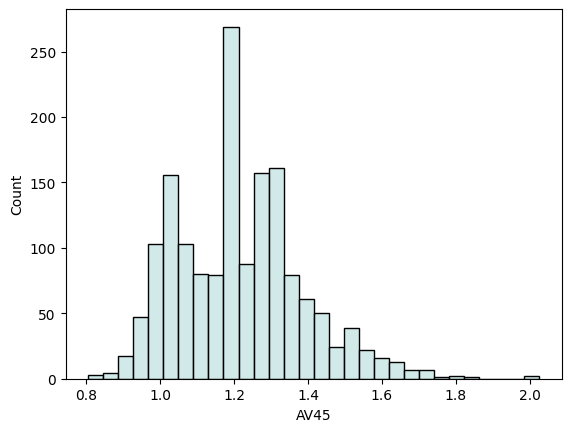

In [256]:
sns.histplot(X_train_brain['AV45']);

In [257]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_brain=scaler.fit_transform(X_train_brain)
X_test_brain=scaler.transform(X_test_brain)

In [258]:
# make arrays X_train_brain and X_test_brain into dataframes (just for easier manipulation, this step does not change the results)
data_train = np.array(X_train_brain)
X_train_brain = pd.DataFrame(data=data_train, columns=columns)
data_test = np.array(X_test_brain)
X_test_brain = pd.DataFrame(data=data_test, columns=columns)

In [259]:
"""
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='3_log_reg_brain_scaled_trans')
run = mlflow.active_run()
"""

"\n# setting the MLFlow connection and experiment\nmlflow.start_run(run_name='3_log_reg_brain_scaled_trans')\nrun = mlflow.active_run()\n"

In [260]:
#Run a simple logistic regression model 

log_reg=LogisticRegression(max_iter=1000)
log_reg.fit(X_train_brain, y_train_brain)

y_pred_train_brain=log_reg.predict(X_train_brain)
y_pred_brain=log_reg.predict(X_test_brain)

accuracy:  0.55


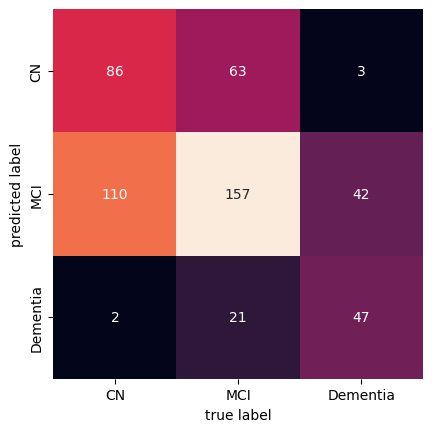

In [261]:
# Plotting the confusing matrix
labels=['CN', 'MCI', 'Dementia']
mat = confusion_matrix(y_test_brain, y_pred_brain, labels=labels)
cm=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
cm.set_xticklabels(labels)
cm.set_yticklabels(labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test_brain, y_pred_brain).round(2))
#print('recall: ' , recall_score(y_test, y_pred).round(2))
#print('precision: ' , precision_score(y_test, y_pred).round(2))

In [262]:
# Check out the metrics
acc_test = accuracy_score(y_test_brain, y_pred_brain)
print(acc_test)
acc_train=accuracy_score(y_train_brain, log_reg.predict(X_train_brain))
print(acc_train)

0.5461393596986818
0.5518541797611565


In [263]:
"""
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)
"""

'\n#logging metrics\nmlflow.log_metric("train-" + "accuracy", acc_train)\nmlflow.log_metric("test-" + "accuracy", acc_test)\n\n# mlflow.sklearn.log_model(reg, "model")\nmlflow.end_run()\n\nmlflow.get_run(run_id=run.info.run_id)\n'

#### 1.3.2 Logistic regression of df_brain - trial with NaN dropped

In [264]:
df_brain.isnull().sum()


FDG             770
AV45           1118
ABETA          1099
TAU             912
PTAU            913
Hippocampus     637
WholeBrain      438
Entorhinal      661
MidTemp         661
DX                0
dtype: int64

In [265]:
#Drop all the missing values
df_brain_2 = df_brain.dropna(axis=0)

In [266]:
df_brain_2.isnull().sum()

FDG            0
AV45           0
ABETA          0
TAU            0
PTAU           0
Hippocampus    0
WholeBrain     0
Entorhinal     0
MidTemp        0
DX             0
dtype: int64

In [267]:
df_brain_2.shape

(515, 10)

In [268]:
#Train test split for the df_brain dataframe to avoid data leakage into our test set 
X_brain_2= df_brain_2.drop('DX', axis=1)
y_brain_2=df_brain_2['DX']
X_train_brain_2, X_test_brain_2, y_train_brain_2, y_test_brain_2=train_test_split(X_brain_2, y_brain_2, random_state=42, stratify=y_brain_2)

In [269]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_brain_2=scaler.fit_transform(X_train_brain_2)
X_test_brain_2=scaler.transform(X_test_brain_2)

In [270]:
# make arrays X_train_brain_2 and X_test_brain_2 into dataframes (just for easier manipulation, this step does not change the results)
data_train = np.array(X_train_brain_2)
X_train_brain_2 = pd.DataFrame(data=data_train, columns=columns)
data_test = np.array(X_test_brain_2)
X_test_brain_2 = pd.DataFrame(data=data_test, columns=columns)

In [271]:
df_brain_2.isnull().sum()

FDG            0
AV45           0
ABETA          0
TAU            0
PTAU           0
Hippocampus    0
WholeBrain     0
Entorhinal     0
MidTemp        0
DX             0
dtype: int64

In [272]:
# make arrays X_train_brain_2 and X_test_brain_2 into dataframes (just for easier manipulation, this step does not change the results)
data_train = np.array(X_train_brain_2)
X_train_brain_2 = pd.DataFrame(data=data_train, columns=columns)
data_test = np.array(X_test_brain_2)
X_test_brain_2 = pd.DataFrame(data=data_test, columns=columns)

In [273]:
"""
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='4_log_reg_brain_scaled_drop')
run = mlflow.active_run()
"""

"\n# setting the MLFlow connection and experiment\nmlflow.start_run(run_name='4_log_reg_brain_scaled_drop')\nrun = mlflow.active_run()\n"

In [274]:
#Run a simple logistic regression model 

log_reg=LogisticRegression(max_iter=1000)
log_reg.fit(X_train_brain_2, y_train_brain_2)

y_pred_train_brain_2=log_reg.predict(X_train_brain_2)
y_pred_brain_2=log_reg.predict(X_test_brain_2)


accuracy:  0.6


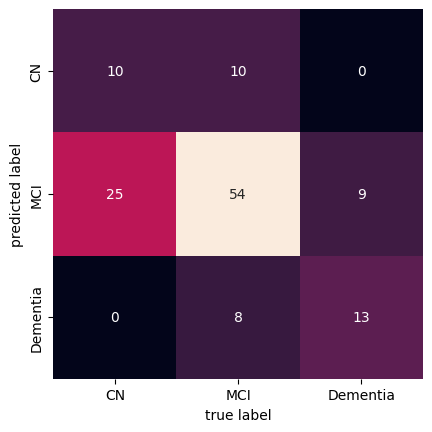

In [275]:
# Plotting the confusing matrix
labels=['CN', 'MCI', 'Dementia']
mat = confusion_matrix(y_test_brain_2, y_pred_brain_2, labels=labels)
cm=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
cm.set_xticklabels(labels)
cm.set_yticklabels(labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test_brain_2, y_pred_brain_2).round(2))
#print('recall: ' , recall_score(y_test, y_pred).round(2))
#print('precision: ' , precision_score(y_test, y_pred).round(2))

In [276]:
# Check out the metrics
acc_test = accuracy_score(y_test_brain_2, y_pred_brain_2)
print(acc_test)
acc_train=accuracy_score(y_train_brain_2, log_reg.predict(X_train_brain_2))
print(acc_train)

0.5968992248062015
0.6217616580310881


____
### 2. Extra trees

### 2.1 Extra trees - df_other

In [277]:
# initiate model
model = ExtraTreesClassifier()
model.fit(X_train_other, y_train_other)

ExtraTreesClassifier()

In [278]:
param_grid = {'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']}

gs = GridSearchCV(SVC(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_other, y_train_other)
gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.654 total time=   0.1s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.671 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.651 total time=   0.1s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.912 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.1s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.934 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.903 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.657 total time=   0.1s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.906 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.574 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.531 total time=   0.1s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [279]:
param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_other, y_train_other)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.918 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.937 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.915 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.937 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.925 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.928 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.903 total time=   0.1s


{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 200}

In [280]:
model = gs.best_estimator_

In [281]:
y_pred_other = model.predict(X_test_other)
acc = accuracy_score(y_test_other, y_pred_other)
print(acc)
accuracy_score(y_train_other, model.predict(X_train_other))

0.9265536723163842


0.9390320553111251

accuracy:  0.93


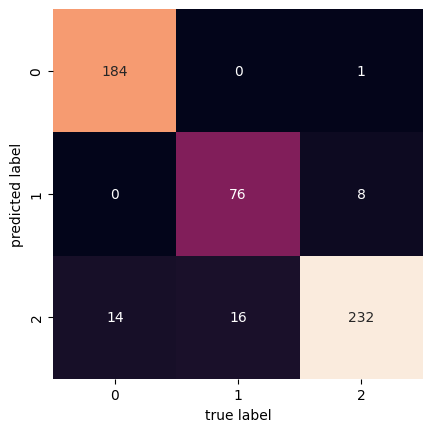

In [282]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test_other, y_pred_other)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test_other, y_pred_other).round(2))
#print('recall: ' , recall_score(y_test_other, y_pred_other).round(2))
#print('precision: ' , precision_score(y_test_other, y_pred_other).round(2))

### 2.2 Extra trees - df_brain
#### 2.2.1 Extra trees of df_brain - trail with NaN filled with KNN

In [289]:
# initiate model
model = ExtraTreesClassifier()
model.fit(X_train_brain, y_train_brain)

ExtraTreesClassifier()

In [291]:
param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_brain, y_train_brain)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.536 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.544 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.607 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.563 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.557 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.604 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.619 total time=   0.1s


{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 50}

In [292]:
model = gs.best_estimator_

In [293]:
y_pred_brain = model.predict(X_test_brain)
acc = accuracy_score(y_test_brain, y_pred_brain)
print(acc)
accuracy_score(y_train_brain, model.predict(X_train_brain))

0.5725047080979284


0.6882463859208046

accuracy:  0.57


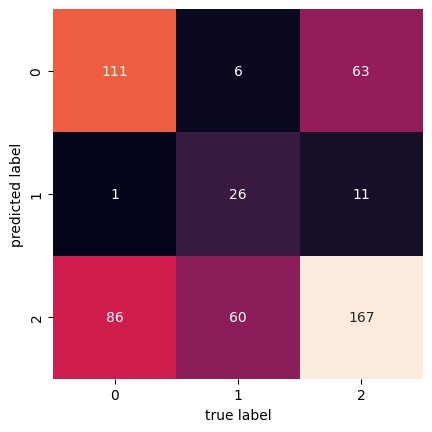

In [294]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test_brain, y_pred_brain)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test_brain, y_pred_brain).round(2))
#print('recall: ' , recall_score(y_test_other, y_pred_other).round(2))
#print('precision: ' , precision_score(y_test_other, y_pred_other).round(2))

#### 2.2.2 Extra trees of df_brain - trial with NaN dropped

In [295]:
# initiate model
model = ExtraTreesClassifier()
model.fit(X_train_brain_2, y_train_brain_2)

ExtraTreesClassifier()

In [296]:
param_grid = {'n_estimators': [50,100,200],
                'criterion': ['gini'],
                'max_depth': [20],
                'min_samples_split': [60],
                'min_samples_leaf': [2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_brain_2, y_train_brain_2)
gs.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.526 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.584 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.584 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.623 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.584 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=50;, score=0.571 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=60, n_estimators=100;, score=0.571 total time=   0.1s


{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 200}

In [297]:
model = gs.best_estimator_

In [298]:
y_pred_brain_2 = model.predict(X_test_brain_2)
acc = accuracy_score(y_test_brain_2, y_pred_brain_2)
print(acc)
accuracy_score(y_train_brain_2, model.predict(X_train_brain_2))

0.5968992248062015


0.6295336787564767

accuracy:  0.6


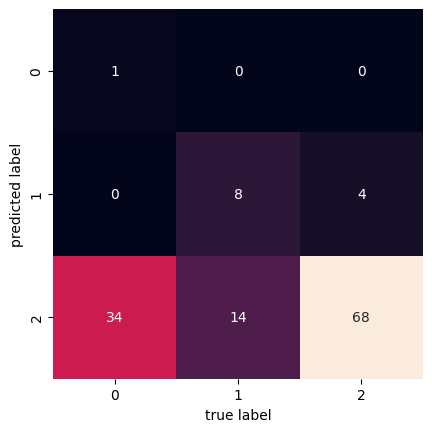

In [299]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test_brain_2, y_pred_brain_2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test_brain_2, y_pred_brain_2).round(2))
#print('recall: ' , recall_score(y_test_other, y_pred_other).round(2))
#print('precision: ' , precision_score(y_test_other, y_pred_other).round(2))

### 3. Support vector clustering (SVC)
### 3.1 SVC - df_other

In [300]:
model = SVC()#C=10, gamma=10, kernel='rbf')
model.fit(X_train_other, y_train_other)

y_pred_other = model.predict(X_test_other)
acc = accuracy_score(y_test_other, y_pred_other)
print(acc)
accuracy_score(y_train_other, model.predict(X_train_other))

0.9246704331450094


0.9365179132620993

In [301]:
param_grid = {'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']}

gs = GridSearchCV(SVC(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_other, y_train_other)
gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.671 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.657 total time=   0.1s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.903 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.912 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.651 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.654 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.1s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.934 total time=   0.1s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.906 total time=   0.1s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.877 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.494 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [302]:
model = gs.best_estimator_

In [303]:
y_pred_other = model.predict(X_test_other)
acc = accuracy_score(y_test_other, y_pred_other)
print(acc)
accuracy_score(y_train_other, model.predict(X_train_other))

0.928436911487759


0.9327467001885607

accuracy:  0.93


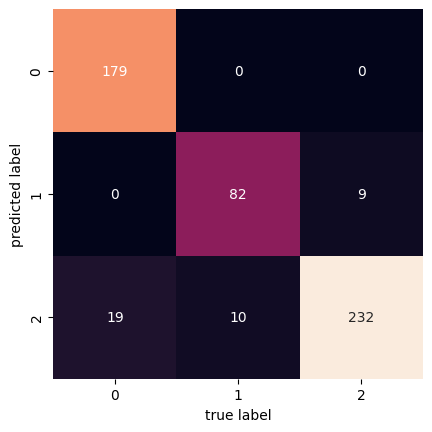

In [305]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test_other, y_pred_other)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test_other, y_pred_other).round(2))
#print('recall: ' , recall_score(y_test_other, y_pred_other).round(2))
#print('precision: ' , precision_score(y_test_other, y_pred_other).round(2))

### 3.2 SVC - df_brain
#### 3.2.1 SVC of df_brain - trial  with NaN filled with KNN

In [306]:
model = SVC()#C=10, gamma=10, kernel='rbf')
model.fit(X_train_brain, y_train_brain)

y_pred_brain = model.predict(X_test_brain)
acc = accuracy_score(y_test_brain, y_pred_brain)
print(acc)
accuracy_score(y_train_brain, model.predict(X_train_brain))

0.5894538606403014


0.6480201131363922